## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import spacy
import re

import xgboost as xgb

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB
from xgboost import XGBClassifier
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import NMF
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

In [4]:
# Initialize the WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
nlp = spacy.load('en_core_web_sm')

## Data

In [5]:
df = pd.read_csv('CLEANDATA/Clean_MT.csv', index_col=False)
df.head()

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3898 entries, 0 to 3897
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        3898 non-null   object
 1   medical_specialty  3898 non-null   object
 2   sample_name        3898 non-null   object
 3   transcription      3898 non-null   object
 4   keywords           3898 non-null   object
dtypes: object(5)
memory usage: 152.4+ KB


In [7]:
df['medical_specialty'].value_counts()

medical_specialty
 Surgery                          1021
 Orthopedic                        303
 Cardiovascular / Pulmonary        280
 Radiology                         251
 Consult - History and Phy.        234
 Gastroenterology                  195
 Neurology                         168
 General Medicine                  146
 SOAP / Chart / Progress Notes     142
 Urology                           140
 Obstetrics / Gynecology           130
 ENT - Otolaryngology               84
 Neurosurgery                       81
 Ophthalmology                      79
 Discharge Summary                  77
 Nephrology                         63
 Hematology - Oncology              62
 Pain Management                    58
 Office Notes                       44
 Pediatrics - Neonatal              42
 Podiatry                           42
 Emergency Room Reports             31
 Dermatology                        25
 Dentistry                          25
 Cosmetic / Plastic Surgery         25
 Letter

### Filtering

In [8]:
# get rows with medical_specialty with more than 100 samples
df = df.groupby('medical_specialty').filter(lambda x: len(x) > 100)

In [9]:
df['medical_specialty'].value_counts()

medical_specialty
 Surgery                          1021
 Orthopedic                        303
 Cardiovascular / Pulmonary        280
 Radiology                         251
 Consult - History and Phy.        234
 Gastroenterology                  195
 Neurology                         168
 General Medicine                  146
 SOAP / Chart / Progress Notes     142
 Urology                           140
 Obstetrics / Gynecology           130
Name: count, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3010 entries, 3 to 3887
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        3010 non-null   object
 1   medical_specialty  3010 non-null   object
 2   sample_name        3010 non-null   object
 3   transcription      3010 non-null   object
 4   keywords           3010 non-null   object
dtypes: object(5)
memory usage: 141.1+ KB


In [11]:
# remove general category
df = df[~df['medical_specialty'].str.contains('Surgery|Consult - History and Phy.|General Medicine|SOAP / Chart / Progress Notes|Radiology')]

In [12]:
df['medical_specialty'].value_counts()

medical_specialty
 Orthopedic                    303
 Cardiovascular / Pulmonary    280
 Gastroenterology              195
 Neurology                     168
 Urology                       140
 Obstetrics / Gynecology       130
Name: count, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1216 entries, 3 to 3887
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        1216 non-null   object
 1   medical_specialty  1216 non-null   object
 2   sample_name        1216 non-null   object
 3   transcription      1216 non-null   object
 4   keywords           1216 non-null   object
dtypes: object(5)
memory usage: 57.0+ KB


## Pre Processing

In [14]:
def Process_Doc(doc):
    # Check if the input is a list, if so, join it into a single string
    if isinstance(doc, list):
        doc = ' '.join(doc)
    # lowercase
    doc = doc.lower()
    # Remove special characters and numbers using regex
    doc = re.sub(r'[^a-zA-Z\s]', '', doc)
    # Remove extra whitespace
    doc = re.sub(r'\s+', ' ', doc).strip()
    # tokenize
    doc = nlp(doc)
    # remove stopwords
    doc = [token.text for token in doc if not token.is_stop and token.is_alpha]
    doc = ' '.join(doc)
    # Lemmatize
    doc = [lemmatizer.lemmatize(word) for word in doc.split()]
    return ' '.join(doc)

In [15]:
sample = df['transcription'].iloc[2]
sample

'2-D ECHOCARDIOGRAM,Multiple views of the heart and great vessels reveal normal intracardiac and great vessel relationships.  Cardiac function is normal.  There is no significant chamber enlargement or hypertrophy.  There is no pericardial effusion or vegetations seen.  Doppler interrogation, including color flow imaging, reveals systemic venous return to the right atrium with normal tricuspid inflow.  Pulmonary outflow is normal at the valve.  Pulmonary venous return is to the left atrium.  The interatrial septum is intact.  Mitral inflow and ascending aorta flow are normal.  The aortic valve is trileaflet.  The coronary arteries appear to be normal in their origins.  The aortic arch is left-sided and patent with normal descending aorta pulsatility.'

In [16]:
Process_Doc(sample)

'd echocardiogrammultiple view heart great vessel reveal normal intracardiac great vessel relationship cardiac function normal significant chamber enlargement hypertrophy pericardial effusion vegetation seen doppler interrogation including color flow imaging reveals systemic venous return right atrium normal tricuspid inflow pulmonary outflow normal valve pulmonary venous return left atrium interatrial septum intact mitral inflow ascending aorta flow normal aortic valve trileaflet coronary artery appear normal origin aortic arch leftsided patent normal descending aorta pulsatility'

## Classification

In [19]:
#preprocess all the transcriptions
df['pr_transcription'] = df['transcription'].apply(Process_Doc)

### Train Test Split

In [20]:
X = df['pr_transcription']
y = df['medical_specialty']

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 972
Testing set size: 244


### Multinomial Naive Bayes

In [36]:
# Create a pipeline
pipeline_MNB = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [37]:
pipeline_MNB.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('nb', MultinomialNB())])

In [38]:
# make predictions
y_pred = pipeline_MNB.predict(X_test)

# evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.8073770491803278


In [39]:
# classification report
print(classification_report(y_test, y_pred))

                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.74      1.00      0.85        49
           Gastroenterology       0.97      0.86      0.91        37
                  Neurology       0.83      0.45      0.59        33
    Obstetrics / Gynecology       1.00      0.61      0.76        28
                 Orthopedic       0.72      0.96      0.82        70
                    Urology       1.00      0.63      0.77        27

                   accuracy                           0.81       244
                  macro avg       0.88      0.75      0.78       244
               weighted avg       0.84      0.81      0.80       244



#### Hypertune NB

In [ ]:
# Grid search

param_grid = { 
    'tfidf__max_df': [0.85, 0.9, 0.95, 1.0],
    'tfidf__min_df': [0.01, 0.1, 1],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_features': [500, 1000, 2000],
    'nb__alpha': (1e-2, 1e-3)
}

In [ ]:
# Set up GridSearchCV
grid_search = GridSearchCV(pipeline_MNB, param_grid, cv=5, n_jobs=-1, verbose=1)

In [ ]:
# Train the model using GridSearchCV to find the best hyperparameters
grid_search.fit(X_train, y_train)

In [ ]:
# Best hyperparameters found by GridSearchCV
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Make predictions on the test set with the best model
y_pred = grid_search.predict(X_test)

In [ ]:
# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))

### KNN

In [ ]:
pipeline_KNN = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [ ]:
pipeline_KNN.fit(X_train, y_train)

In [ ]:
# make predictions
y_pred = pipeline_KNN.predict(X_test)

# evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

#### Hypertune KNN

In [ ]:
# Define the parameter grid for KNN
param_grid_knn = {
    'tfidf__max_df': [0.85, 0.9, 0.95, 1.0],
    'tfidf__min_df': [0.01, 0.1, 1],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_features': [500, 1000],
    'knn__n_neighbors': [3, 5],
    'knn__weights': ['uniform'],
    'knn__metric': ['euclidean', 'manhattan']
}

# Set up GridSearchCV for KNN
grid_search_knn = GridSearchCV(pipeline_KNN, param_grid_knn, cv=5, n_jobs=-1, verbose=1)

# Train the model using GridSearchCV to find the best hyperparameters
grid_search_knn.fit(X_train, y_train)

# Best hyperparameters found by GridSearchCV
print(f"Best Hyperparameters for KNN: {grid_search_knn.best_params_}")

# Make predictions on the test set with the best model
y_pred_knn = grid_search_knn.predict(X_test)

# Evaluate the classifier
print("Classification Report for KNN:")
print(classification_report(y_test, y_pred_knn))

### XGBoost

In [ ]:
pipeline_XGB = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('xgb', XGBClassifier())
])

In [ ]:
# Encode the target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

pipeline_XGB.fit(X_train, y_train_encoded)

In [ ]:
# make predictions
y_pred = pipeline_XGB.predict(X_test)

# evaluate the model
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred)}")

#### Hypertune XGBoost

In [ ]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'tfidf__max_df': [0.85, 0.9, 0.95, 1.0],
    'tfidf__min_df': [0.01, 0.1, 1],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_features': [500, 1000],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__max_depth': [3, 5]
}

# Set up GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(pipeline_XGB, param_grid_xgb, cv=5, n_jobs=-1, verbose=1)

# Train the model using GridSearchCV to find the best hyperparameters
grid_search_xgb.fit(X_train, y_train_encoded)

# Best hyperparameters found by GridSearchCV
print(f"Best Hyperparameters for XGBoost: {grid_search_xgb.best_params_}")

# Make predictions on the test set with the best model
y_pred_xgb = grid_search_xgb.predict(X_test)

# Evaluate the classifier
print("Classification Report for XGBoost:")
print(classification_report(y_test_encoded, y_pred_xgb))

### Random Forest

In [ ]:
pipeline_RF = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rand', RandomForestClassifier())
])

In [ ]:
pipeline_RF.fit(X_train, y_train)

In [ ]:
# make predictions
y_pred = pipeline_RF.predict(X_test)

# evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

#### Hypertune Random Forest

In [ ]:
# Define the parameter grid for RandomForest
param_grid_rf = {
    'tfidf__max_df': [0.85, 0.9, 0.95, 1.0],
    'tfidf__min_df': [0.01, 0.1, 1],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_features': [500, 1000, 2000],
    'rand__n_estimators': [100, 200, 300],
    'rand__max_depth': [None, 10, 20, 30],
    'rand__min_samples_split': [2, 5, 10],
    'rand__min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV for RandomForest
grid_search_rf = GridSearchCV(pipeline_RF, param_grid_rf, cv=5, n_jobs=-1, verbose=1)

# Train the model using GridSearchCV to find the best hyperparameters
grid_search_rf.fit(X_train, y_train)

# Best hyperparameters found by GridSearchCV
print(f"Best Hyperparameters for RandomForest: {grid_search_rf.best_params_}")

# Make predictions on the test set with the best model
y_pred_rf = grid_search_rf.predict(X_test)

# Evaluate the classifier
print("Classification Report for RandomForest:")
print(classification_report(y_test, y_pred_rf))

### Complement Naive Bayes

In [22]:
pipeline_CNB = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('comp', ComplementNB())
])

In [23]:
pipeline_CNB.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('comp', ComplementNB())])

In [24]:
# make predictions
y_pred = pipeline_CNB.predict(X_test)

# evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.9262295081967213


#### Hypertune ComplementNB

In [25]:
# hyperparameter tuning for ComplementNB

param_grid = {
    'tfidf__max_df': [0.85, 0.9, 0.95, 1.0],
    'tfidf__min_df': [0.01, 0.1, 1],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__max_features': [500, 1000, 2000],
    'comp__alpha': (0.01, 0.1, 1, 10)
}

In [26]:
# Set up GridSearchCV
grid_search = GridSearchCV(pipeline_CNB, param_grid, cv=5, n_jobs=-1, verbose=1)

In [27]:
# Train the model using GridSearchCV to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Best hyperparameters found by GridSearchCV
print(f"Best Hyperparameters: {grid_search.best_params_}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Hyperparameters: {'comp__alpha': 0.01, 'tfidf__max_df': 0.85, 'tfidf__max_features': 2000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}


In [28]:
# Make predictions on the test set with the best model
y_pred = grid_search.predict(X_test)

# Evaluate the classifier
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                             precision    recall  f1-score   support

 Cardiovascular / Pulmonary       0.90      0.96      0.93        49
           Gastroenterology       1.00      0.92      0.96        37
                  Neurology       0.76      0.79      0.78        33
    Obstetrics / Gynecology       1.00      0.96      0.98        28
                 Orthopedic       0.93      0.93      0.93        70
                    Urology       0.96      0.96      0.96        27

                   accuracy                           0.92       244
                  macro avg       0.93      0.92      0.92       244
               weighted avg       0.92      0.92      0.92       244



In [29]:
# evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.9221311475409836


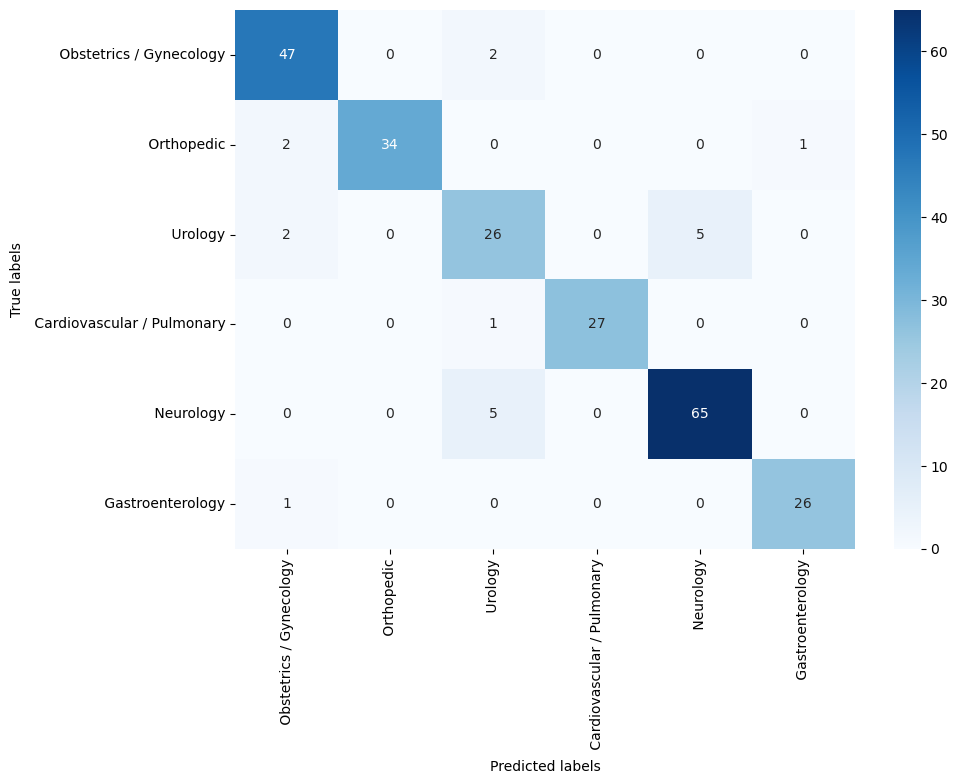

In [30]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_test.unique(), yticklabels=y_test.unique())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

------------

In [31]:
import pickle

with open('model.pkl', 'wb') as file:
    pickle.dump(grid_search, file)

## Word Cloud

In [ ]:
# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['pr_transcription']))

# Display the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Extract the TfidfVectorizer from the pipeline
tfidf = pipeline_CNB.named_steps['tfidf']

# Fit and transform the data to get the tf-idf matrix
tfidf_matrix = tfidf.fit_transform(df['pr_transcription'])

# Get the feature names (words)
feature_names = tfidf.get_feature_names_out()

# Sum the tf-idf values for each word
word_scores = tfidf_matrix.sum(axis=0).A1

# Create a dictionary of words and their scores
word_freq = dict(zip(feature_names, word_scores))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [32]:
# Feature extraction using NMF
# Extract the TfidfVectorizer from the pipeline
tfidf = pipeline_CNB.named_steps['tfidf']

# Fit and transform the data to get the tf-idf matrix
tfidf_matrix = tfidf.fit_transform(df['pr_transcription'])

# Get the feature names (words)
feature_names = tfidf.get_feature_names_out()

# Sum the tf-idf values for each word
word_scores = tfidf_matrix.sum(axis=0).A1

# Create a dictionary of words and their scores
word_freq = dict(zip(feature_names, word_scores))

# Sort the words by their scores in descending order
important_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Display the top 10 important words
important_words[:10]

[('patient', 63.381877340610544),
 ('right', 47.4774516186809),
 ('left', 46.45468026360197),
 ('placed', 35.4374876557933),
 ('normal', 31.564385120073727),
 ('procedure', 30.338936049557486),
 ('diagnosis', 26.21494738519346),
 ('artery', 22.839647138540798),
 ('incision', 22.563370202915298),
 ('noted', 20.548028193976553)]

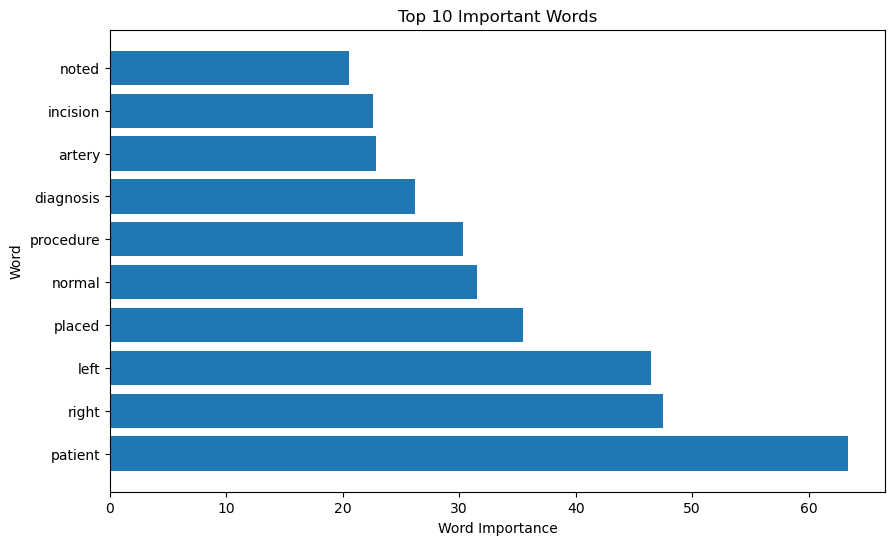

In [33]:
# plot the top 10 important words
plt.figure(figsize=(10, 6))
plt.barh([word[0] for word in important_words[:10]], [word[1] for word in important_words[:10]])
plt.xlabel('Word Importance')
plt.ylabel('Word')
plt.title('Top 10 Important Words')
plt.show()

In [34]:
# Fit the TfidfVectorizer on the preprocessed transcriptions
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df['pr_transcription'])

# Get the feature names (words)
feature_names = tfidf.get_feature_names_out()

# Create a DataFrame with the tf-idf scores
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Add the medical_specialty column to the DataFrame
tfidf_df['medical_specialty'] = df['medical_specialty'].values

# Group by medical_specialty and calculate the mean tf-idf score for each word
grouped_tfidf = tfidf_df.groupby('medical_specialty').mean()

# Get the top 10 important words for each medical specialty
important_words_per_specialty = {}
for specialty in grouped_tfidf.index:
    important_words = grouped_tfidf.loc[specialty].sort_values(ascending=False).head(10)
    important_words_per_specialty[specialty] = important_words.index.tolist()

important_words_per_specialty

{' Cardiovascular / Pulmonary': ['artery',
  'left',
  'coronary',
  'patient',
  'right',
  'chest',
  'catheter',
  'normal',
  'pulmonary',
  'heart'],
 ' Gastroenterology': ['colon',
  'patient',
  'gallbladder',
  'scope',
  'procedure',
  'stomach',
  'normal',
  'polyp',
  'esophagus',
  'abdomen'],
 ' Neurology': ['right',
  'left',
  'normal',
  'brain',
  'patient',
  'mri',
  'exam',
  'revealed',
  'temporal',
  'tumor'],
 ' Obstetrics / Gynecology': ['uterus',
  'patient',
  'uterine',
  'cervix',
  'vaginal',
  'placed',
  'cm',
  'breast',
  'delivery',
  'fetal'],
 ' Orthopedic': ['patient',
  'right',
  'left',
  'placed',
  'knee',
  'fracture',
  'carpal',
  'medial',
  'tendon',
  'joint'],
 ' Urology': ['bladder',
  'patient',
  'prostate',
  'inguinal',
  'placed',
  'testis',
  'suture',
  'procedure',
  'penis',
  'right']}

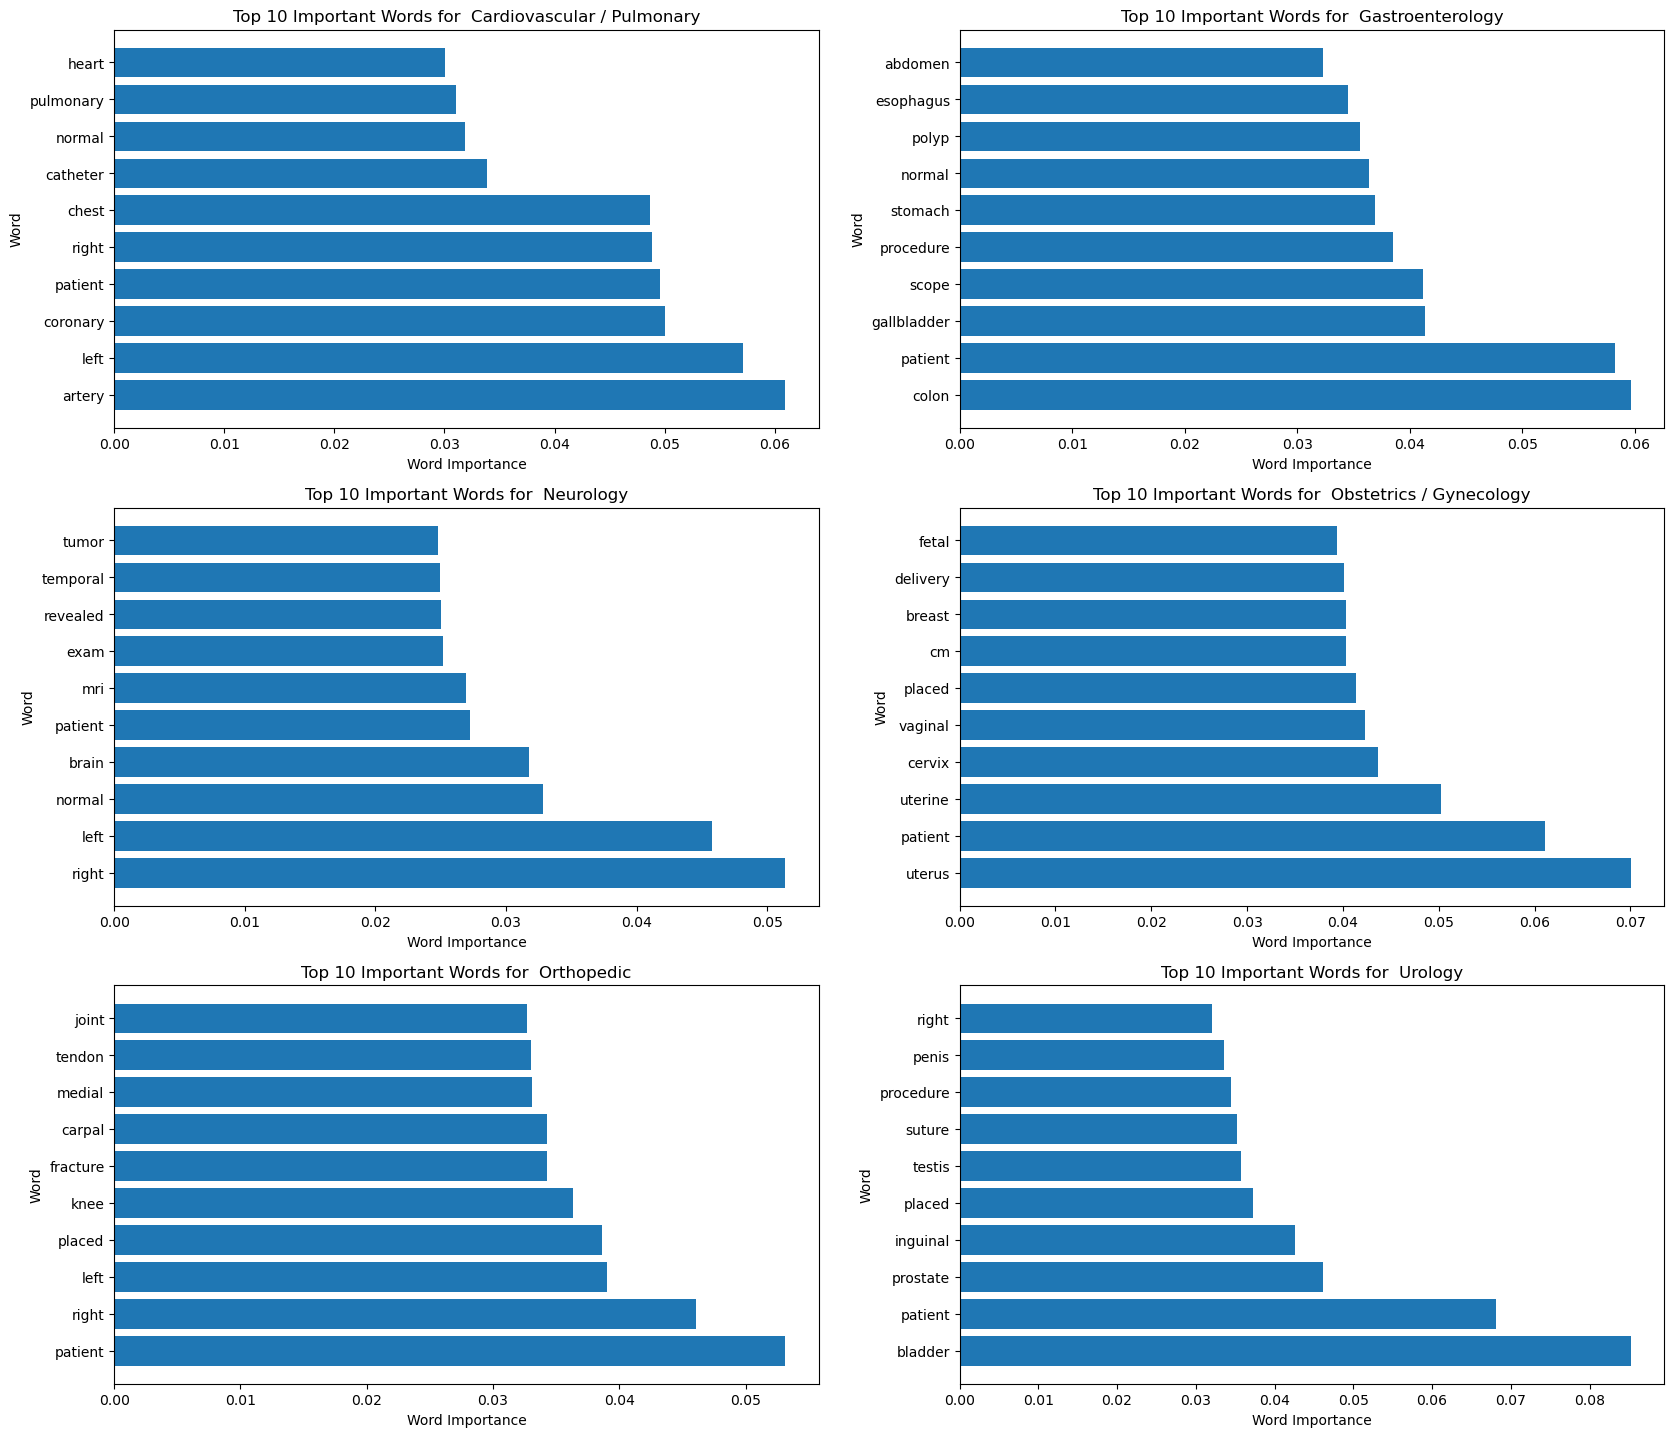

In [35]:
# plot the top 10 important words for each medical specialty
plt.figure(figsize=(20, 30))
for i, (specialty, words) in enumerate(important_words_per_specialty.items()):
    plt.subplot(5, 2, i+1)
    plt.barh(words, grouped_tfidf.loc[specialty, words])
    plt.xlabel('Word Importance')
    plt.ylabel('Word')
    plt.title(f'Top 10 Important Words for {specialty}')